<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jaiio/00-03-consolidaci%C3%B3n_train_test_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo 50 JAIIO: Consolidación del dataset
__Título:__ Etiquetado semi-supervisado multiclase de correos electrónicos a partir de estrategias de extracción de características y _Elasticsearch_

__Autores:__ Juan Manuel Fernandez, Marcelo Errecalde


En esta notebook se consolidan las clases de los correos que forman parte del trabajo dado que se encontraron clases solapadas y ejemplos mal clasificados:

## 0. Misceláneos:

### Descarga de librerias necesarias

In [1]:
!pip install requests
!pip install wget

In [2]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import consolidar_df, get_clases

### Descarga dataset de train y test

Se descargan los datasets con 800 correos en el caso de train y 200 correos para el de test:

In [3]:
# Descargo los correos ya etiquetados
from os import path

if not (path.exists('correos-train-80.csv')):
    !wget https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/correos-train-80.csv

if not (path.exists('correos-test-20.csv')):
    !wget https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/correos-test-20.csv

## 1. Presentación del dataset:

### 1.1 Se levanta en un DataFrame para poder manipularlo

In [4]:
import pandas as pd

# Cargo correos en un dataframe
correos_train = pd.read_csv('correos-train-80.csv')
correos_test = pd.read_csv('correos-test-20.csv')

## 2. Representación de las clases

Pasan a representarse las clases a partir de la etiqueta y no del valor numérico discretizado:


### 2.1 Transformación de las clases identificadas por el experto

In [5]:
from sklearn.preprocessing import LabelEncoder

clases = get_clases()

# Instancio el transformador
le = LabelEncoder()

# Discretizo
clases_disc = le.fit_transform(clases)

# Muestro clases originales
print(f'Clases originales:\n{clases}\n')

# Muestro clases discretizadas
print(f'Clases discretizadas:\n{clases_disc}\n')

# Accedo a la clase original por su valor discretizado
print(f'Acceso a la original, de id {2} con discretizada: {clases[clases_disc[2]]}')

Clases originales:
['Boleto Universitario' 'Cambio de Carrera' 'Cambio de Comisión'
 'Carga de Notas' 'Certificados Web' 'Consulta por Equivalencias'
 'Consulta por Legajo' 'Consulta sobre Título Universitario' 'Cursadas'
 'Datos Personales' 'Exámenes' 'Ingreso a la Universidad'
 'Inscripción a Cursadas' 'Pedido de Certificados'
 'Problemas con la Clave' 'Reincorporación' 'Requisitos de Ingreso'
 'Simultaneidad de Carreras' 'Situación Académica' 'Vacunas Enfermería']

Clases discretizadas:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

Acceso a la original, de id 2 con discretizada: Cambio de Comisión


### 2.2 Creación de un dataframe con las clases originales sin discretizar

In [6]:
# Aplico una transformacion inversa para des-discretizar
correos_train['clase'] = le.inverse_transform(correos_train['clase'])
correos_test['clase'] = le.inverse_transform(correos_test['clase'])

total_etiquetados = pd.concat([correos_train, correos_test])

# Muestro las primeras 5 clases originales
correos_train['clase'].head()
correos_test['clase'].head()

0        Boleto Universitario
1       Requisitos de Ingreso
2            Datos Personales
3    Ingreso a la Universidad
4             Reincorporación
Name: clase, dtype: object

### 2.3 Unificación del dataset

Se unifica el dataset de train y test en un único dataset. Luego se vuelve a separar en train y test:

In [7]:
import pandas as pd

correos_etiquetados = pd.concat([correos_train, correos_test], ignore_index=True)

## 3. Reorganización de las clases

A partir de falencias en el etiquetado encontradas en la construcción del modelo, se mejora el etiquetado en dos aspectos:
1. Se reorganizan las clases,
2. Se re-etiquetan algunas instancias

Además, se guardarán los correos con las clases sin discretizar (etiquetas textuales).


### 3.1 Reorganización de las clases

En este aspecto, se realizan los siguientes cambios:
- La clase 'Vacunas Enfermería' se unifica con 'Reguisitos de Ingreso'.
- La clase 'Inscripción a Cursadas' se unifica con 'Cursadas'.
- La clase 'Certificados Web' se unifica con 'Pedido de Certificados' que a su vez pasa a llamarse 'Emisión de Certificados'.
- La clase 'Carga de Notas' se unifica con 'Situación Académica'.

In [8]:
correos_etiquetados['clase'] = correos_etiquetados['clase'].replace(['Vacunas Enfermería'], 'Requisitos de Ingreso')

In [9]:
correos_etiquetados['clase'] = correos_etiquetados['clase'].replace(['Inscripción a Cursadas'], 'Cursadas')

In [10]:
correos_etiquetados['clase'] = correos_etiquetados['clase'].replace(['Certificados Web'], 'Pedido de Certificados')

In [11]:
correos_etiquetados['clase'] = correos_etiquetados['clase'].replace(['Carga de Notas'], 'Situación Académica')

In [12]:
import numpy as np

np.sort(correos_etiquetados['clase'].unique())

array(['Boleto Universitario', 'Cambio de Carrera', 'Cambio de Comisión',
       'Consulta por Equivalencias', 'Consulta por Legajo',
       'Consulta sobre Título Universitario', 'Cursadas',
       'Datos Personales', 'Exámenes', 'Ingreso a la Universidad',
       'Pedido de Certificados', 'Problemas con la Clave',
       'Reincorporación', 'Requisitos de Ingreso',
       'Simultaneidad de Carreras', 'Situación Académica'], dtype=object)

### 3.2 Re-etiquetado de Instancias

En este aspecto, se vuelven a etiquetar instancias que estaban mal etiquetadas.

En primer lugar se des-setea el ancho de la columna para poder visualizar todo el texto de las consultas:


In [13]:
pd.set_option('display.max_colwidth', None)

El proceso consiste en visualizar el texto de las instancias para asegurarnos del reemplazo correcto con el siguiente código: <br />
`correos_etiquetados.loc[[2]][['Consulta', 'clase']]` <br />
Y luego el reemplazo con el método `at`: <br />
`correos_etiquetados.at[2, 'clase'] = 'Reincorporación'`

Además, se crea una función para realizar modificaciones de clase a partir del texto de la consulta:

In [14]:
def modificar_clase(df, texto_consulta, nueva_clase):
  '''
  Esta función modifica el atributo "clase" asignado a un correo a partir de 
  comparar texto_consulta contra el atributo "Consulta"
  '''
  # Se busca el índice
  indice = int(df.query(f"Consulta == '{texto_consulta}'").index.values)

  if indice:
    # Se reemplaza con la clase que corresponde
    df.at[indice, 'clase'] = nueva_clase
 
  return df, indice

#### 3.2.1 Re-etiquetado de Instancias por id

Comienza el re-etiquetado de instancias:

In [15]:
print(correos_test.loc[[2]][['Consulta', 'clase']])
correos_test.at[2, 'clase'] = 'Reincorporación'
print(correos_test.loc[[2]][['Consulta', 'clase']])

                                                                                                                                                                                                                                                                                                                                       Consulta             clase
2  buenas tardes,  me dicen que tengo que reincribirme pero no puedo acceder a la direccion del correo que me indican que me va ha llegar debido que la cuenta fue bloqueada. les pido por favor si pueden enviarme el enace para realizar la reincripcion a esta cuenta . hasta que pueda acceder a mi cuenta . gracias y espero su respuesta   Datos Personales
                                                                                                                                                                                                                                                                                                    

In [16]:
# Se transcribe la consulta
consulta = "buenas tardes,  me dicen que tengo que reincribirme pero no puedo acceder a la direccion del correo que me indican que me va ha llegar debido que la cuenta fue bloqueada. les pido por favor si pueden enviarme el enace para realizar la reincripcion a esta cuenta . hasta que pueda acceder a mi cuenta . gracias y espero su respuesta "

# Se busca el índice
indice = int(correos_etiquetados.query(f"Consulta == '{consulta}'").index.values)

# Se reemplaza con la clase que corresponde
correos_etiquetados.at[indice, 'clase'] = 'Reincorporación'

# Se muestra
correos_etiquetados.query(f"Consulta == '{consulta}'")

,Consulta,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,clase
802,"buenas tardes, me dicen que tengo que reincribirme pero no puedo acceder a la direccion del correo que me indican que me va ha llegar debido que la cuenta fue bloqueada. les pido por favor si pueden enviarme el enace para realizar la reincripcion a esta cuenta . hasta que pueda acceder a mi cuenta . gracias y espero su respuesta",1,4,2,1,2017,2,1,1,1,1,5,13,332,0.0,0.801205,0,63,35,0.746032,0.012048,3,0,Reincorporación


In [17]:
# Se transcribe la consulta
consulta = "buenas tardes,para hacerle una consulta.. como hago con las solicitudes de inscripción para aspirantes rechazadas.. intento de nuevo o tengo q elegir otros horarios?! desde ya gracias "

# Se busca el índice
indice = int(correos_etiquetados.query(f"Consulta == '{consulta}'").index.values)

# Se reemplaza con la clase que corresponde
correos_etiquetados.at[indice, 'clase'] = 'Cursadas'

# Se muestra
correos_etiquetados.query(f"Consulta == '{consulta}'")

,Consulta,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,clase
554,"buenas tardes,para hacerle una consulta.. como hago con las solicitudes de inscripción para aspirantes rechazadas.. intento de nuevo o tengo q elegir otros horarios?! desde ya gracias",3,3,2,1,2019,1,4,0,0,1,43,6,184,0.0,0.815217,1,28,12,0.964286,0.038043,4,0,Cursadas


In [18]:
# Se transcribe la consulta
consulta = "no puedo inscribirme a las materias de este cuatrimestre  "

# Se busca el índice
indice = int(correos_etiquetados.query(f"Consulta == '{consulta}'").index.values)

# Se reemplaza con la clase que corresponde
correos_etiquetados.at[indice, 'clase'] = 'Cursadas'

# Se muestra
correos_etiquetados.query(f"Consulta == '{consulta}'")

,Consulta,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,clase
274,no puedo inscribirme a las materias de este cuatrimestre,2,1,3,1,2019,3,4,2,1,1,3,6,58,0.0,0.827586,0,11,7,0.909091,0.0,1,0,Cursadas


In [19]:
# Se transcribe la consulta
consulta = "buen dia. necesito regularizarme y saber si voy a poder anotarme en alguna cursada debo generar una nueva clave y contraseña? muchas gracias "

# Se busca el índice
indice = int(correos_etiquetados.query(f"Consulta == '{consulta}'").index.values)

# Se reemplaza con la clase que corresponde
correos_etiquetados.at[indice, 'clase'] = 'Cursadas'

# Se muestra
correos_etiquetados.query(f"Consulta == '{consulta}'")[['Consulta', 'clase']]

,Consulta,clase
232,buen dia. necesito regularizarme y saber si voy a poder anotarme en alguna cursada debo generar una nueva clave y contraseña? muchas gracias,Cursadas


In [20]:
consulta = 'necesito informacion sobre mi situacion academica materias aprobadas y condicion  '

# Se busca el índice
indice = int(correos_etiquetados.query(f"Consulta == '{consulta}'").index.values)

# Se reemplaza con la clase que corresponde
correos_etiquetados.at[indice, 'clase'] = 'Situación Académica'

# Se muestra
correos_etiquetados.query(f"Consulta == '{consulta}'")[['Consulta', 'clase']]

,Consulta,clase
366,necesito informacion sobre mi situacion academica materias aprobadas y condicion,Situación Académica


In [21]:
consulta = 'no puedo inscribirme  a las materias del  primer cuatrimestre. '

# Se busca el índice
indice = int(correos_etiquetados.query(f"Consulta == '{consulta}'").index.values)

# Se reemplaza con la clase que corresponde
correos_etiquetados.at[indice, 'clase'] = 'Cursadas'

# Se muestra
correos_etiquetados.query(f"Consulta == '{consulta}'")[['Consulta', 'clase']]

,Consulta,clase
495,no puedo inscribirme a las materias del primer cuatrimestre.,Cursadas


In [22]:
consulta = 'hola.. intente ingresar a mi situación académica y no pude. dice que ya no tengo acceso al sistema.. yo ya me recibi.. pero quiero un certicado de título en trámite.. y saber cuándo me van a dar el título.. me dijeron que era en junio.. me podrían decir cuando puedo tener esos certificados y cuando me dan el título.. y como hago para ingresar a mi situación académica.. gracias. '

# Se busca el índice
indice = int(correos_etiquetados.query(f"Consulta == '{consulta}'").index.values)

# Se reemplaza con la clase que corresponde
correos_etiquetados.at[indice, 'clase'] = 'Consulta sobre Título Universitario'

# Se muestra
correos_etiquetados.query(f"Consulta == '{consulta}'")[['Consulta', 'clase']]

,Consulta,clase
772,hola.. intente ingresar a mi situación académica y no pude. dice que ya no tengo acceso al sistema.. yo ya me recibi.. pero quiero un certicado de título en trámite.. y saber cuándo me van a dar el título.. me dijeron que era en junio.. me podrían decir cuando puedo tener esos certificados y cuando me dan el título.. y como hago para ingresar a mi situación académica.. gracias.,Consulta sobre Título Universitario


#### 3.2.2 Re-etiquetado de Instancias por texto de la consulta

A continuación se avanza sobre modificaciones de clase en correos a partir de texto:

In [23]:
consulta = 'me comunico con la intención de saber en que situacion académica me encuentro, ya que califique con cuatro en  el taller de lectura y comprension de textos. '

# Se busca el índice
indice = int(correos_etiquetados.query(f"Consulta == '{consulta}'").index.values)

# Se reemplaza con la clase que corresponde
correos_etiquetados.at[indice, 'clase'] = 'Situación Académica'

# Se muestra
correos_etiquetados.query(f"Consulta == '{consulta}'")[['Consulta', 'clase']]

,Consulta,clase
611,"me comunico con la intención de saber en que situacion académica me encuentro, ya que califique con cuatro en el taller de lectura y comprension de textos.",Situación Académica


In [24]:
consulta = 'quiero restablecer mi contraseña pero no llega el mail a mi correo que es este mismo quiero anotarme en los finales muchas gracias ! '
correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')

print(f'Se modifica el indice {id}.')

Se modifica el indice 25.


In [25]:
consulta = 'buenos días, no puedo ingresar a mi perfil, ya solicite un restablecimiento de clave pero no recibí ningún mail. necesitaría por favor ver la forma de solucionarlo antes del cierre de inscripciones para finales en septiembre. muchas gracias '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')

print(f'Se modifica el indice {id}.')

Se modifica el indice 26.


In [26]:
consulta = 'hola quisiera saber que tengo que hacer si al intentar restablecer mi contraseña para acceder a la plataforma, no me llega el mail para seguir con el procedimiento muchas gracias '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')

print(f'Se modifica el indice {id}.')

Se modifica el indice 27.


In [27]:
consulta = 'buenos dias,  me remito a ustedes para consultar el por qué de que no pueda hacer la solicitud de título correspondiente a técnica universitaria en comercio exterior y aduanas.  por favor si podrían darme una respuesta a la brevedad ya que necesitaría con suma urgencia la certificación.  gracias. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Consulta sobre Título Universitario')
print(f'Se modifica el indice {id}.')

Se modifica el indice 49.


In [28]:
consulta = 'hola, soy cruz elizabeth, aspirante a ingenieria agronomica y queria saber por que no puedo inscribirme para cursar las materias??  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Cursadas')
print(f'Se modifica el indice {id}.')

Se modifica el indice 53.


In [29]:
consulta = 'por que no me puedo inscribir en las materias  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Cursadas')
print(f'Se modifica el indice {id}.')

Se modifica el indice 54.


In [30]:
consulta = 'buen dia pedi la solicitud de reinscripcion en la universidad,aproximadamente hace dos meses,con respuesta inmediata y positiva.el problema es que cuando quiero ingresar desde el perfil de estudiante me sale una leyenda que dice que no me encuentro regular en la carrera. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Reincorporación')
print(f'Se modifica el indice {id}.')

Se modifica el indice 58.


In [31]:
consulta = 'olvide mi clave para entrar al sistema e inscribirme a las cursadas pero hice todo el procedimiento y aun no me llega el mail para recuperar mi clave. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 81.


In [32]:
consulta = 'no puedo entrar a mi perfil de estudiante y no me ha llegado un mail para restablecer mi contraseña '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 83.


In [33]:
consulta = 'me inscribí y no me deja seguir me pone dirigirse a la sede más cercana me pone que figuro como alumna '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Reincorporación')
print(f'Se modifica el indice {id}.')

Se modifica el indice 116.


In [34]:
consulta = 'perdi la regularidad como alumna. y en mi correo no me aparece formulario de reinscripcion '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Reincorporación')
print(f'Se modifica el indice {id}.')

Se modifica el indice 136.


In [35]:
consulta = 'no me deja ingresar a las materias con mi número de documento ni tampoco contraseña.  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 154.


In [36]:
consulta = 'hola no puedo ingresar con mi contraseña a mi perfil y no me llegan el mail para reestablecer la clave. desde ya muchas gracias '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 171.


In [37]:
consulta = 'no me llega el email para reestablecer la contraseña '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 202.


In [38]:
consulta = 'no me llega el email para confirmar mi nueva clave '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 204.


In [39]:
consulta = 'hola! olvidé la contraseña y no me lkega el mail de recuperación.  gracias '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 212.


In [40]:
consulta = 'olvide mi contraseña para acceder al perfil de estudiante, quiero actualizarla, ingrese los datos que me pedía pero todavía no me llego el mail para que pueda actualizarla. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 215.


In [41]:
consulta = 'hola, realice mi inscripcion a la carrera de licenciatura de enfermeria pero aun no me llega la respuesta a mi correo electronico para realizar el siguiente paso abra alguna posibilidad que verifiquen el incombeniente porfavor. desde muchas gracias. laura gonzalez '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Ingreso a la Universidad')
print(f'Se modifica el indice {id}.')

Se modifica el indice 227.


In [42]:
consulta = 'cuando quiero entrar a mi nformación académica desde mi perfil de estudiantes no me deja, dice que no cumplo con los requisitos necesarios. y yo soy estudiante del año pasado y metí una materia y ahora no puedo entrar para inscribirme a las materias de este año  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Requisitos de Ingreso')
print(f'Se modifica el indice {id}.')

Se modifica el indice 231.


In [43]:
consulta = 'me olvidé la contraseña para ingresar y poder anotarme a las materias. y a mí e-mail no me llega nada para restablecerla. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 233.


In [44]:
consulta = 'quisiera recuperar mi clave de acceso al sistema de servicios académicos, ya gestioné la clave pero no me llega el mail. gracias '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 236.


In [45]:
consulta = 'mi consulta es sobre la materia introduccion al trabajo social yo la curse en 2016 mi pregunta es el vencimiento de la regularidad si es de 2 o3 años si es de 2 años mi ultima posibilidad seria ahora en diciembre esa es mi consulta.muchas gracias  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Situación Académica')
print(f'Se modifica el indice {id}.')

Se modifica el indice 246.


In [46]:
consulta = 'buenas tardes, me olvide la contraseña y no me llega el mail para poder cambiarlo.  desde ya muchas gracias. saludos '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 268.


In [47]:
consulta = 'hola no puedo entrar, yo ya soy estudiante, por favor me podrían ayudar con esto, o informarme que tengo que hacer. desde ya muchas gracias.  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 287.


In [48]:
consulta = 'hola, entro a mi cuenta y aparezco como que no soy alumno regular. me dice que registre un mail para regularizar mi situacion pero no tengo nada en mi correo... me podran decir como tengo que hacer por favor '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Reincorporación')
print(f'Se modifica el indice {id}.')

Se modifica el indice 296.


In [49]:
consulta = 'burnos dias.hace varios dias estoy esperando el reestablecimiento de la clave de ingreso a la plataforma y no me ha llegado nada a mi casilla de correo, a los fines de que no se produzca mas demora quisiera solicitar que se corrobore la casilla de mail ya que la misma es vanina.aquiles04@hotmail.com '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 319.


In [50]:
consulta = 'buenas tardes,no puedo ingresar para la inscricion de examenes pongo numero de lejago y la clave que me dieron y me dice que es incorrecto ,me podrian decir que puedo hacer para ingresar .muchas gracias.   '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 323.


In [51]:
consulta = 'no recuerdo mi clave hice todo el procedimiento y nunca me llego el mail. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 337.


In [52]:
consulta = 'buenos días. el día viernes me acerque a la sede de san miguel para realizar el trámite de reincorporación y me dijieron que hoy me fijara en la pagina . pero sigo sin poder ingresar. puse mi legajo y la clave que me generaron ahí. no se si tendré que esperar unos días más? gracias  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Reincorporación')
print(f'Se modifica el indice {id}.')

Se modifica el indice 342.


In [53]:
consulta = 'no puedo ingresar a ver mi situación académica, ingrese en la opción que me da de &quot;olvidaste tu clave&quot; complete lo que me pide, pero no me llega el mail. ya lo hice varias veces.  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 343.


In [54]:
consulta = 'es la segunda vez que restablezco la contraseña y no recibo ningún correo. estoy necesitando con urgencia ingresar a la pagina. como puedo hacer para verificar que mi correo este bien registrado? muchas gracias. '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 347.


In [55]:
consulta = 'buenas tardes, quiero acceder a la inscripción de asignaturas del 1er cuatrimestre, y me indica que ingrese el número de legajo, pero no lo tengo, como lo obtengo? '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Consulta por Legajo')
print(f'Se modifica el indice {id}.')

Se modifica el indice 361.


In [56]:
consulta = 'intento restablecer la contraseña pero nunca me llega el mail para hacerlo '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 362.


In [57]:
consulta = 'no puedo entrar a mi situación académica, y cuando envío el formulario para cambiar la contraseña no me llega nada al correo  '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 364.


In [58]:
consulta = 'reseteo la clave pero no me llega ningun correo '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 374.


In [59]:
consulta = 'buenas tardes, ya pedi el cambio de contraseña pero no me llega el mail para reestablecerla '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 391.


In [60]:
consulta = 'estimados, soy alumno regular y no recuerdo mi clave para ingresar a ingresar a insc para cursar. solicité blanque de contraseña pero no recibo el mail para realizarlo.   '

correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, 'Problemas con la Clave')
print(f'Se modifica el indice {id}.')

Se modifica el indice 408.


In [61]:
# consulta = ''

# correos_etiquetados, id = modificar_clase(correos_etiquetados, consulta, '')
# print(f'Se modifica el indice {id}.')

In [62]:
correos_etiquetados.clase.unique()

array(['Cursadas', 'Cambio de Carrera', 'Reincorporación',
       'Ingreso a la Universidad', 'Boleto Universitario',
       'Pedido de Certificados', 'Exámenes', 'Requisitos de Ingreso',
       'Problemas con la Clave', 'Situación Académica',
       'Consulta por Legajo', 'Consulta sobre Título Universitario',
       'Simultaneidad de Carreras', 'Cambio de Comisión',
       'Consulta por Equivalencias', 'Datos Personales'], dtype=object)

## 4. Reorganización de los atributos

Se definen todos los nombres de atributos en minúsculas:

In [63]:
correos_etiquetados = correos_etiquetados.rename(columns=str.lower)

## 5. Conteo de frecuencias de las Clases

### 5.1 Histograma de Clases

A continuación se plantea una función para graficar el histograma de clases (gráfico de barras con frecuencia observada por clase):


			Distribución de clases para el Total dataset


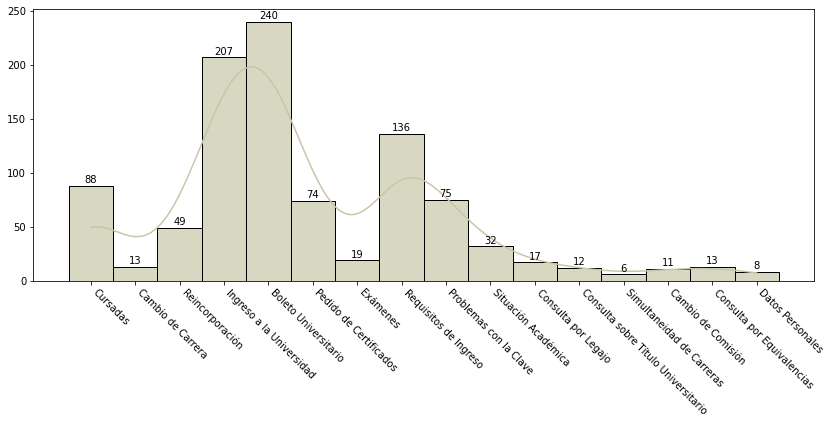

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

def hist_clases(serie_clases, desc_plot, filename_plot):
  """
  Se plotean las clases en función de la distribución de la frecuencia
  observada en cada dataset
  """

  # Set figure size
  plt.figure(figsize=(14,5))

  ax = sns.histplot(serie_clases, kde=True, stat='count', 
                    bins=serie_clases.unique(), binwidth=0.06, 
                    color='#c8c6a7', alpha=0.7)

  ax.set_xticklabels(serie_clases.unique(),
                    rotation=-45, 
                    horizontalalignment='left', fontweight='light')

  for p in ax.patches:
      ax.annotate(f'{p.get_height():.0f}\n',
                  (p.get_x() + p.get_width() / 2, p.get_height()), 
                  ha='center', va='center', color='black')

  # Quito el nombre de los ejes (de forma rústica)
  plt.xlabel('', fontsize=12)
  plt.ylabel('', fontsize=12)

  # Guardo el plot en un png
  plt.savefig(filename_plot, optimize=True, transparent=True, bbox_inches = 'tight')

  # Muestro el gráfico con una descripción
  print(f'\t\t\tDistribución de clases para el {desc_plot}')
  plt.show()  

hist_clases(correos_etiquetados['clase'], 'Total dataset', 'histograma_total.png')

In [65]:
correos_etiquetados.shape

(1000, 24)

In [66]:
correos_etiquetados.to_csv('correos.csv')

In [67]:
!ls

correos.csv	     correos-train-80.csv  funciones_dataset.py  __pycache__
correos-test-20.csv  drive		   histograma_total.png  sample_data


## 6. Train/Test dataset

Ahora, se splitean los datasets a en una proporción 80/20. Estos datasets se utilizarán para _feature extraction_ y para la generación de los modelos:

In [68]:
# Separo datos de entrenamiento y testing
from sklearn.model_selection import train_test_split

X = correos_etiquetados.drop(columns=['clase'])
y = correos_etiquetados['clase']

# Separo en 80-20 entrenamiento/validación y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, stratify=y)

Ahora unificamos X e y para persistir los datasets:

In [69]:
# Reordeno el índice para poder concatenar con el y_train e y_test

# Train
df_train = X_train.reset_index(drop=True)
df_train['clase'] = y_train.reset_index(drop=True)

# Test
df_test = X_test.reset_index(drop=True)
df_test['clase'] = y_test.reset_index(drop=True)

In [70]:
df_test[['consulta', 'clase']]

,consulta,clase
0,"buenas tardes, ingrese a inscripcion a cursadas y me dice que me enviaron un mail pero no me llego nada. estoy intentando hace varios dias",Ingreso a la Universidad
1,"hola que tal, tengo muchas dudas. quiero saber mi numero de legajo y mi clave y no se como obtenerla.voy formulario de solicitud de restablecimiento de clave , y me dice que mi tipo y documento son incorrectos",Ingreso a la Universidad
2,"buenas tardes, queria hacerles una consulta, estoy intentando hacer la solicitud para inscribirme en las materias para el primer cuatrimestre y me dice que no puedo. como podria solucionarlo ? muchas gracias.",Requisitos de Ingreso
3,"necesito ayuda urgente. donde dice actividades académicas, en la fotocopia para el cambio de carrera, pongo el nombre de las materias? por favor necesito respuesta",Cambio de Carrera
4,"hola buenas tardes, deseo informar que mi nuevo correo es : efraingauto@hotmail.com, manifiesto esto por que quiero realizar un cambio de clave en acceso a información académica y me indica que me envían información a mi correo pero nunca me llega. gracias.",Datos Personales
...,...,...
195,hola buenas noches quería saber alguna fecha estimativa de la aprobación los cambios de comisión . muchas gracias,Cambio de Comisión
196,"buen día, queria consultar con quien puedo hablar por el tema del boleto estudiantial. muchas gracias.",Boleto Universitario
197,no recibo el mail para poder inscribirme a las materias.,Cursadas
198,necesito obtener el certificado de materias aprobadas. tambien conocer como es el tramite para la re inscripcion (si es posible),Pedido de Certificados


Por último se persisten en _Drive_:

In [71]:
# Me autentico en Drive
from google.colab import drive

# Guardo en Drive los datos de entrenamiento
df_train.to_csv('correos-train-jaiio-80.csv', index=False)
drive.mount('drive')
!cp correos-train-jaiio-80.csv "drive/My Drive/"

# Guardo en Drive los datos de testeo
df_test.to_csv('correos-test-jaiio-20.csv', index=False)
drive.mount('drive')
!cp correos-test-jaiio-20.csv "drive/My Drive/"

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [72]:
# Me autentico en Drive
from google.colab import drive

# Guardo en Drive los datos de entrenamiento
correos_etiquetados.to_csv('correos.csv')
drive.mount('drive')
!cp correos.csv "drive/My Drive/"


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


# Referencias:
1. [Presentación](0) de apoyo al [Proyecto de Investigación](1) "Clasificación automática de correos electrónicos".

2. Clasificacion de textos por etiquetado de palabras: [short paper](2).

3. [API](3) del diccionario Collins.

4. [Funciones](4) de la [API](3) del diccionario Collins.

5. Librería [clusteval](5) para la evaluación KMeans.

[0]:https://docs.google.com/presentation/d/1-gdZ3dUI2pAfXM6Bgau53U7G4g2Bkv6DlxGESnu7A20/edit?usp=sharing 
[1]:https://github.com/jumafernandez/clasificacion_correos 
[2]:https://www.aaai.org/Papers/AAAI/2004/AAAI04-068.pdf
[3]:https://pypi.org/project/collins-client/
[4]:https://api.collinsdictionary.com/api/v1/documentation/html
[5]:https://clusteval.sdu.dk/1/mains